In [70]:
import numpy as np
import pandas as pd
import os

dataset_list = ['TCGA-SKCM']
clinical_path = '/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/6.NK_analysis/TCGA-SKCM/clinical.tsv'
gem_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/6.NK_analysis/TCGA-SKCM/gem.csv'
outputdir = '/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/6.NK_analysis/TCGA-SKCM'

gem_df = pd.read_csv(gem_path, index_col=0, header=0)
clinical_data = pd.read_csv(clinical_path, index_col=0, header=0, delimiter='\t')
clinical_pharmaceutical = clinical_data[clinical_data['treatment_type'] == 'Pharmaceutical Therapy, NOS']
clinical_radiation = clinical_data[clinical_data['treatment_type'] == 'Radiation Therapy, NOS']
survival_df1 = clinical_pharmaceutical[['days_to_death', 'days_to_last_follow_up', 'vital_status']]
survival_df2 = clinical_radiation[['days_to_death', 'days_to_last_follow_up', 'vital_status']]

def get_day_to_event(x):
    if x['vital_status'] == "Dead":
        return x['days_to_death']
    else:
        return x['days_to_last_follow_up']
survival_df1['days_to_event'] = survival_df1.apply(lambda x: get_day_to_event(x), axis=1)
survival_df2['days_to_event'] = survival_df2.apply(lambda x: get_day_to_event(x), axis=1)
survival_df1['days_to_event'].replace('\'--', 0.0, inplace=True)
survival_df2['days_to_event'].replace('\'--', 0.0, inplace=True)
survival_df1['days_to_event'] = survival_df1['days_to_event'].astype(float)
survival_df2['days_to_event'] = survival_df2['days_to_event'].astype(float)

def get_group(x):
    if x['vital_status'] == "Dead":
        return 1
    else:
        return 0
survival_df1['death'] = survival_df1.apply(lambda x: get_group(x), axis=1)
survival_df2['death'] = survival_df2.apply(lambda x: get_group(x), axis=1)

NK_IL18_IFNG_signature = ["NCR1", "NCR3", "KLRB1", "CD160", "PRF1", "IL18", "IL18", "IFNG"]
NK_IL18_IFNG = gem_df.loc[NK_IL18_IFNG_signature, :].mean()
NK_IL18_IFNG_high_sample = NK_IL18_IFNG[NK_IL18_IFNG > NK_IL18_IFNG.quantile(q=0.75)].index
NK_IL18_IFNG_low_sample = NK_IL18_IFNG[NK_IL18_IFNG < NK_IL18_IFNG.quantile(q=0.25)].index
    
def get_group(x):
    if x in NK_IL18_IFNG_high_sample:
        return "high"
    if x in NK_IL18_IFNG_low_sample:
        return "low"
survival_df1['group'] = survival_df1.index.map(lambda x: get_group(x))
survival_df2['group'] = survival_df2.index.map(lambda x: get_group(x))
survival_df1 = survival_df1[survival_df1['group'].isin(['low', 'high'])]
survival_df2 = survival_df2[survival_df2['group'].isin(['low', 'high'])]

survival_df1.to_csv(os.path.join(outputdir, 'survival_pharmaceutical.csv'))
survival_df2.to_csv(os.path.join(outputdir, 'survival_radiation.csv'))

/var/tmp/ipykernel_216534/644128200.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survival_df1['days_to_event'] = survival_df1.apply(lambda x: get_day_to_event(x), axis=1)
/var/tmp/ipykernel_216534/644128200.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survival_df2['days_to_event'] = survival_df2.apply(lambda x: get_day_to_event(x), axis=1)
/var/tmp/ipykernel_216534/644128200.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using 

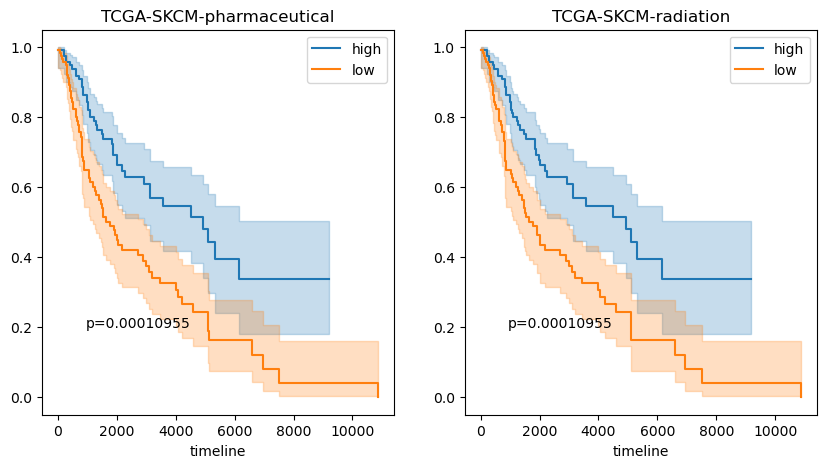

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

dataset_list = ['TCGA-SKCM']
fig = plt.figure(figsize=(10, 5 * len(dataset_list)))
gs = gridspec.GridSpec(nrows=len(dataset_list), ncols=2, width_ratios=[1, 1])
for dataset in dataset_list:
    survival_path1 = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/6.NK_analysis/{dataset}/survival_pharmaceutical.csv'
    survival_path2 = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/6.NK_analysis/{dataset}/survival_radiation.csv'
    
    for i in range(2):
        survival_df = survival_df1 if i == 0 else survival_df2
        therapy = 'pharmaceutical' if i == 0 else 'radiation'
        
        ax = fig.add_subplot(gs[0, i])
        kmf = KaplanMeierFitter() # KM初始化
        for group_name, group_data in survival_df.groupby('group'):
            kmf.fit(group_data["days_to_event"], group_data["death"], label=group_name)
            kmf.plot_survival_function()
                        
        flag = (survival_df['group'] == 'high')
        time = survival_df["days_to_event"]
        death = survival_df["death"]
        results = logrank_test(time[flag], time[~flag], death[flag], death[~flag], alpha=.99)
        ax.set_title(f"{dataset}-{therapy}")
        ax.text(max(time) / 4, 0.2, f'p={"{:.8f}".format(results.p_value)}', ha='center', fontsize=10)  

In [69]:
time

case_id
0153f141-625e-4623-9f8a-296678002c63       422
01cb0004-fc1e-4da5-9d27-f458f8d711ee       787
021a9431-7fdc-42b8-9ff0-e17ded79ff1d    4533.0
04f7ecc8-4f6b-41ac-a984-9ea604698a21    2010.0
080bb1f8-f20c-4daa-9de3-b5782b69583c     214.0
                                         ...  
fa099993-ef30-4eff-a8fb-aa41b5ea671a       821
fb620e8b-4be7-4e53-af04-8e9c27b4dcf0    1109.0
fd1a49f2-fb3b-481d-888e-f4224d59f6d1    1716.0
fdbbdbf8-cf2e-4550-9727-b023aed9b8d9       190
fecff768-2cf4-487f-8ea4-c24a947330b7      4930
Name: days_to_event, Length: 234, dtype: object